# MODEL AGNOSTIC TEST

This notebook allows to perform a model agnostic test, allowing two different framework to be compared. The only stric requiremnt is that the model produces, as output, a feature vector that is used to compare images.

In [1]:
from multiprocess import cpu_count
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import tensorflow as tf
import numpy as np
from sklearn.metrics import pairwise_distances
import seaborn
import pandas as pd

from tensorflow_similarity.samplers import MultiShotMemorySampler
from tensorflow_similarity.samplers import RandAugment
from tensorflow_similarity.architectures import EfficientNetSim
from tensorflow_similarity.losses import MultiSimilarityLoss
from tensorflow_similarity.visualization import confusion_matrix  # matching performance

import glob
import os
import sys
partial_path = os.getcwd().rsplit("/", 1)[0]
sys.path.insert(0, f"{partial_path}/src/")
from test_utils import test_agnostic_get_metrics, test_agnostic_show_pics
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

2022-05-30 13:50:20.317779: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


### TEST SET DEFINITION

Test images have to be in the form "../{damage_id}_{photo_id}.*"

In [2]:
base_path = '../data/test_BDEO_remapped/'
print(len(os.listdir(base_path)))
all_files = glob.glob(os.path.join(base_path, '*'))

385


In [3]:
damages_ids=set([int(os.path.basename(i).split('_')[0]) for i in all_files])

### MODEL DEFINITION

In [4]:
IMG_SIZE = 256
embedding_size = 256
model = EfficientNetSim((IMG_SIZE, IMG_SIZE, 3), embedding_size=embedding_size, augmentation=None)
model.summary()

2022-05-30 13:50:26.019345: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-05-30 13:50:27.079463: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0001:00:00.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-05-30 13:50:27.079497: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-05-30 13:50:27.082999: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-05-30 13:50:27.083124: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-05-30 13:50:27.083929: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2022-0

Model: "similarity_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
metric_embedding (MetricEmbe (None, 256)               327936    
Total params: 4,377,507
Trainable params: 327,936
Non-trainable params: 4,049,571
_________________________________________________________________


In [5]:
model

In [6]:
model = tf.keras.models.load_model("../models/LEGACY_best_tfsim_model/best_tf_sim_model")

Distance metric automatically set to cosine use the distance arg to override.


In [7]:
query=[]
gallery=[]

puntatore=0
for path in all_files:
    dam_id=int(os.path.basename(path).split('_')[0])
    if dam_id==puntatore:
        query.append(path)
        puntatore+=1
    elif dam_id==puntatore-1:
        gallery.append(path)
    else:
        puntatore+=1

In [8]:
query_idx=np.array([int(os.path.basename(path).split('_')[0]) for path in query])
gallery_idx=np.array([int(os.path.basename(path).split('_')[0]) for path in gallery])

In [9]:
@tf.function()
def process_val(p):
    img = tf.io.decode_image(p)
    img = tf.image.resize_with_crop_or_pad(img, IMG_SIZE, IMG_SIZE)
    return img

def loader_val(x, y, sample_per_batch, is_warmup):

    imgs = []
    for p in x:
       imgs.append(tf.io.read_file(p))
    imgs = tf.stack(imgs)
    imgs = tf.map_fn(process_val, 
                     imgs, 
                     parallel_iterations=cpu_count(),
                     dtype='uint8')
    return imgs, y

In [10]:
query_loaded=loader_val(query, query_idx, None, None)[0]
gallery_loaded=loader_val(gallery, gallery_idx, None, None)[0]

2022-05-30 13:50:42.300575: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-30 13:50:42.320202: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2445445000 Hz


In [11]:
query_feat=model.predict(query_loaded)
gallery_feat=model.predict(gallery_loaded)

2022-05-30 13:50:44.070525: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-05-30 13:50:44.461360: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100
2022-05-30 13:50:44.951533: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-30 13:50:44.951583: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2022-05-30 13:50:44.952145: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-30 13:50:44.952214: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-05-30 13:50:44.983183: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully ope

In [ ]:
test_agnostic_show_pics(query,query_idx,  query_feat,
               gallery,gallery_idx,  gallery_feat)

  0%|          | 0/132 [00:00<?, ?it/s]

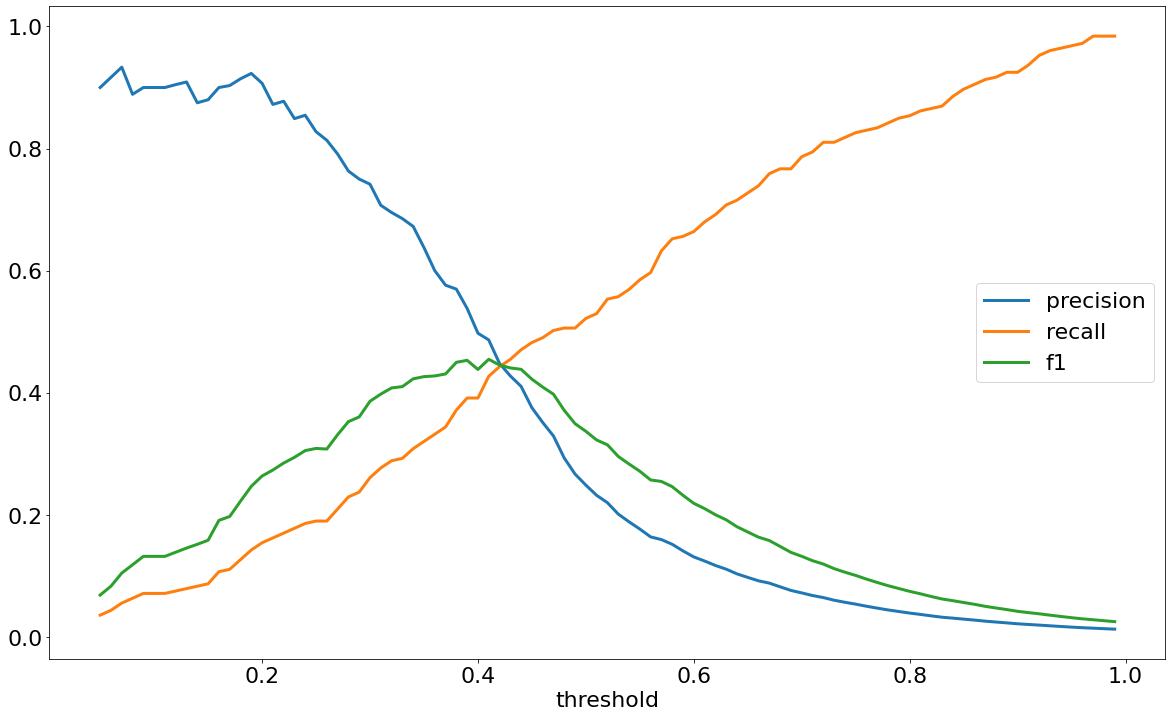

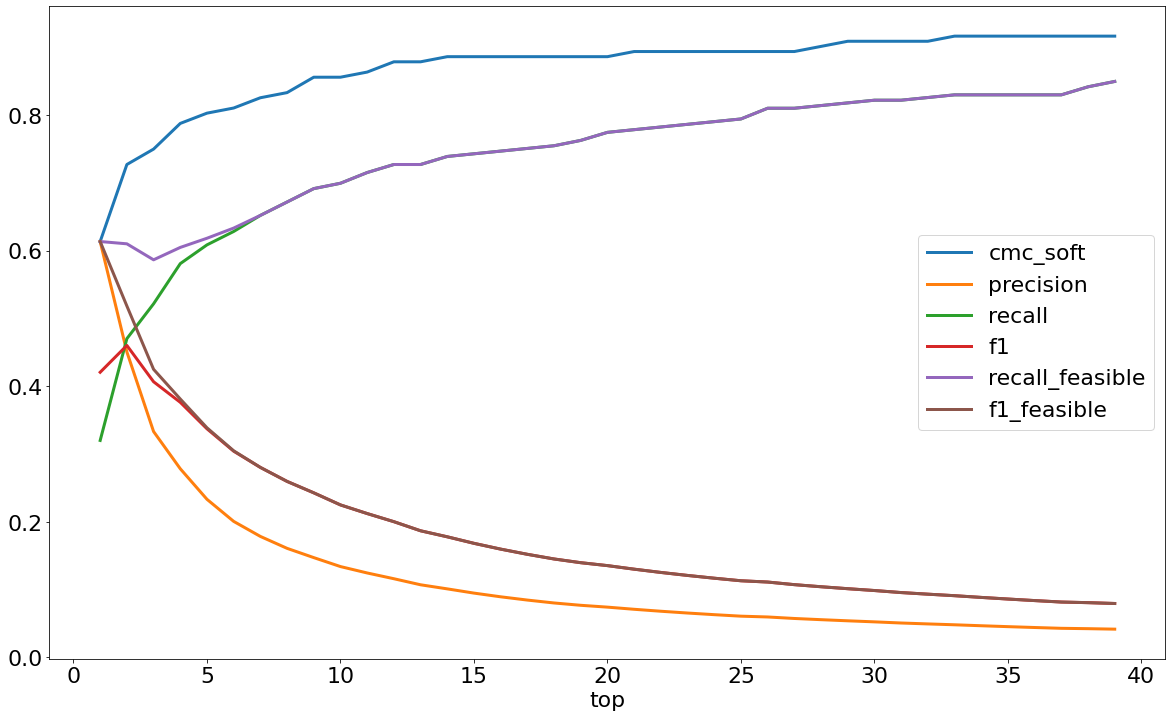

In [13]:
out=test_agnostic_get_metrics(query,query_idx,  query_feat,
               gallery,gallery_idx,  gallery_feat, 
               thresholds=np.arange(0.05,1,0.01), top=list(reversed(range(40)))[0:-1])

In [14]:
out=test_agnostic_get_metrics(query,query_idx,  query_feat,
               gallery,gallery_idx,  gallery_feat, 
               thresholds=np.arange(0.1,0.3,0.02), top=(10, 5, 3, 1),
               display_metrics=True, plot_curves=False)

  0%|          | 0/132 [00:00<?, ?it/s]

,top,precision,recall,recall_feasible,f1,f1_feasible,cmc_soft
top_10,10,0.134091,0.699605,0.699605,0.225048,0.225048,0.856061
top_5,5,0.233333,0.608696,0.618474,0.337349,0.338834,0.803030
top_3,3,0.333333,0.521739,0.586667,0.406780,0.425121,0.750000
top_1,1,0.613636,0.320158,0.613636,0.420779,0.613636,0.613636


,threshold,precision,recall,f1
trash_0.1,0.10,0.900000,0.071146,0.131868
trash_0.12,0.12,0.904762,0.075099,0.138686
trash_0.14,0.14,0.875000,0.083004,0.151625
trash_0.16,0.16,0.900000,0.106719,0.190813
trash_0.18,0.18,0.914286,0.126482,0.222222
trash_0.2,0.20,0.906977,0.154150,0.263513
trash_0.22,0.22,0.877551,0.169960,0.284768
trash_0.24,0.24,0.854545,0.185771,0.305195
trash_0.26,0.26,0.813559,0.189723,0.307692
trash_0.28,0.28,0.763158,0.229249,0.352584


In [24]:
out=test_agnostic_get_metrics(query,query_idx,  query_feat,
               gallery,gallery_idx,  gallery_feat, 
               thresholds=np.arange(0.2,1,0.005), top=list(reversed(range(40)))[0:-1], 
               get_summary_metrics=True, plot_curves=False)

  0%|          | 0/132 [00:00<?, ?it/s]

mean average precision (mAP) is: 0.614
top-1 soft-positive Cumulative Matching Characteristics (CMC) is: 0.614
top-5 f1 feasible is : top_5    0.339
Name: f1_feasible, dtype: float64
top-10 f1 feasible is: top_10    0.225
Name: f1_feasible, dtype: float64
recall at 0.95 is:  0.162
recall at 0.9 is:  0.154
recall at 0.5 is:  0.391


In [23]:
out[1][0:50]

,threshold,precision,recall,f1
trash_0.1,0.100,0.900000,0.071146,0.131868
trash_0.11,0.105,0.900000,0.071146,0.131868
trash_0.11,0.110,0.900000,0.071146,0.131868
trash_0.12,0.115,0.900000,0.071146,0.131868
trash_0.12,0.120,0.904762,0.075099,0.138686
trash_0.13,0.125,0.904762,0.075099,0.138686
trash_0.13,0.130,0.909091,0.079051,0.145455
trash_0.14,0.135,0.869565,0.079051,0.144928
trash_0.14,0.140,0.875000,0.083004,0.151625
trash_0.15,0.145,0.880000,0.086957,0.158273
